In [1]:
import sys
sys.path.append("../")  # 프로젝트 루트를 경로에 추가
from model import create_model
import re 
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/dhai/anaconda3/envs/monai_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# UNet 모델 생성 (2D 데이터 예제)
unet_model = create_model(
    model_type="unet",        # UNet 모델 타입
    in_channels=4,           # 입력 채널 수
    out_channels=1           # 출력 채널 수 (클래스 수)
).cuda()

print("UNet Model:")
print(unet_model)

UNet Model:
UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
     

In [3]:
class WrinkleDataset(Dataset):
    def __init__(self, rgb_paths, depth_paths, label_paths, transform=None, min_depth=55.0, max_depth=247.0):
        """
        Args:
            rgb_paths (str): RGB 이미지 경로.
            depth_paths (str): Depth 맵 경로.
            label_paths (str): Masked Texture Map 경로.
            transform (callable, optional): 데이터 변환 함수.
        """
        self.rgb_paths = rgb_paths
        self.depth_paths = depth_paths
        self.label_paths = label_paths
        self.transform = transform

        # RGB 이미지 정규화를 위한 평균과 표준편차
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        
        # Depth 이미지 정규화를 위한 최소값과 최대값
        self.min_depth = min_depth
        self.max_depth = max_depth

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgb_path = self.rgb_paths[idx]
        depth_path = self.depth_paths[idx]
        label_path = self.label_paths[idx]

        # RGB 및 Depth 이미지 로드
        rgb_image =  np.array(Image.open(rgb_path).convert("RGB")).astype(np.float32)
        rgb_image = rgb_image / 255.0  # [0, 1] 범위로 스케일링
        
        depth_image = np.array(Image.open(depth_path).convert("L")).astype(np.float32)
        depth_image = (depth_image - self.min_depth) / (self.max_depth - self.min_depth)
        depth_image = np.clip(depth_image, 0, 1)
        depth_image = np.expand_dims(depth_image, axis=-1)  # (H, W, 1)

        # 4채널 입력 생성
        input_image  = np.concatenate((rgb_image, depth_image), axis=-1)  # (H, W, 4)

        # Label (Masked Texture Map) 로드
        label = np.array(Image.open(label_path).convert("L")).astype(np.float32)
        label = label / 255.0

        # Transform 적용
        if self.transform:
            augmented = self.transform(image=input_image, mask=label)
            input_image = augmented['image']
            label = augmented['mask']
        else:
            # ToTensor 변환
            input_image = ToTensorV2()(image=input_image)['image']
            label = ToTensorV2()(image=label)['image']

        return input_image , label
# 데이터 증강 함수 정의     
def get_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, p=0.2),  # 'affine' 인자 제거
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
        A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=0.2),
        A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.1), rotate=(-15, 15), shear=(-10, 10), p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406, 0.0), std=(0.229, 0.224, 0.225, 1.0)),  # Depth 채널 포함
        ToTensorV2()
    ])

scaler = GradScaler()

# 학습 및 검증 함수
def train_epoch(loader, model, criterion, optimizer):
    model.train()
    epoch_loss = 0
    for inputs, labels in tqdm(loader, desc="Training"):
        inputs, labels = inputs.cuda(), labels.cuda()

        labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()
        
        # Forward
        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def validate_epoch(loader, model, criterion, epoch):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(tqdm(loader, desc="Validation")):
            inputs, labels = inputs.cuda(), labels.cuda()
            labels = labels.unsqueeze(1)
            with autocast(device_type='cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            # 일부 예측 결과 저장
            if idx < 5:  # 처음 5개 배치의 결과를 저장
                save_pretraining_results(inputs, outputs, labels, epoch, idx)
                
    return epoch_loss / len(loader)

# 전체 Depth 이미지에서 최소값과 최대값 계산
def calculate_depth_min_max(depth_paths):
    min_depth = float('inf')
    max_depth = float('-inf')

    for depth_path in depth_paths:
        depth_image = np.array(Image.open(depth_path).convert("L")).astype(np.float32)
        min_depth = min(min_depth, depth_image.min())
        max_depth = max(max_depth, depth_image.max())

    return min_depth, max_depth


# 모든 파일 경로 수집 함수
def collect_file_paths(root_dir, start_folder=0, end_folder=49000):
    file_paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # 현재 폴더의 이름 추출
        current_folder = os.path.basename(dirpath)
        # 폴더 이름이 숫자로만 이루어져 있는지 확인
        if current_folder.isdigit():
            folder_number = int(current_folder)
            # 폴더 번호가 범위 내에 있는지 확인
            if start_folder <= folder_number <= end_folder:
                for filename in filenames:
                    if filename.endswith('.png') and filename not in manual_mask_files:
                        # 파일 이름에서 숫자 부분 추출
                        file_base_name = filename[:-4]  # '.png' 제거
                        # 숫자로만 이루어진 파일 이름인지 확인
                        if re.fullmatch(r'\d+', file_base_name):
                            file_paths.append(os.path.join(dirpath, filename))
    return sorted(file_paths)

# 매칭된 파일 경로 리스트 생성
def get_folder_name(file_name):
    file_base_name = file_name[:-4]  # '.png' 제거
    # 파일 이름에서 숫자 부분 추출
    number_str = ''.join(filter(str.isdigit, file_base_name))
    if number_str == '':
        raise ValueError(f"파일 이름에서 숫자를 추출할 수 없습니다: {file_name}")
    number = int(number_str)
    folder_number = (number // 1000) * 1000
    folder_name = f"{folder_number:05d}"
    return folder_name

def save_pretraining_results(inputs, outputs, labels, epoch, batch_idx):
    # 배치에서 첫 번째 이미지 사용
    input_image = inputs[0].cpu().detach()
    output_image = outputs[0].cpu().detach()
    label_image = labels[0].cpu().detach()
    
    # 입력 이미지의 RGB 채널만 사용
    input_image_rgb = input_image[:3]  # RGB 채널
    
    # 시각화를 위해 [0, 1] 범위로 스케일링
    input_image_rgb = (input_image_rgb - input_image_rgb.min()) / (input_image_rgb.max() - input_image_rgb.min())
    if len(output_image.shape) == 2:
        output_image = output_image.unsqueeze(0)  # shape: (1, H, W)
    if len(label_image.shape) == 2:
        label_image = label_image.unsqueeze(0)    # shape: (1, H, W)

    # 시각화를 위해 [0, 1] 범위로 스케일링
    output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())
    label_image = (label_image - label_image.min()) / (label_image.max() - label_image.min())
    
    
    # TensorBoard에 이미지 추가
    writer.add_image(f'Validation/Input_Epoch_{epoch}_Batch_{batch_idx}', input_image_rgb, epoch)
    writer.add_image(f'Validation/Predicted_Epoch_{epoch}_Batch_{batch_idx}', output_image, epoch)
    writer.add_image(f'Validation/GroundTruth_Epoch_{epoch}_Batch_{batch_idx}', label_image, epoch)


In [4]:
# 데이터 로더 정의
rgb_dir = "../data/images1024x1024"
depth_dir = "../data/depth_masking"
label_dir = "../data/weak_wrinkle_masks"

# Ground Truth 주름 마스크 파일 이름 수집
manual_mask_dir = "../data/manual_wrinkle_masks"
manual_mask_files = []

for dirpath, dirnames, filenames in os.walk(manual_mask_dir):
    for filename in filenames:
        if filename.endswith('.png'):
            manual_mask_files.append(filename)

manual_mask_files = set(manual_mask_files)  # 집합으로 변환하여 검색 속도 향상
    
# RGB, Depth, Label 파일 경로 수집
rgb_paths = collect_file_paths(rgb_dir, start_folder=0, end_folder=49000)
depth_paths = collect_file_paths(depth_dir, start_folder=0, end_folder=49000)
label_paths = collect_file_paths(label_dir, start_folder=0, end_folder=49000)

# 파일 이름만 추출하여 리스트 생성
rgb_files = [os.path.basename(path) for path in rgb_paths]
depth_files = [os.path.basename(path) for path in depth_paths]
label_files = [os.path.basename(path) for path in label_paths]

# 파일 이름이 동일한 것들만 매칭
common_files = set(rgb_files) & set(depth_files) & set(label_files)
common_files = sorted(list(common_files))

# 매칭된 파일 경로 리스트 생성
rgb_paths = [os.path.join(rgb_dir, get_folder_name(f), f) for f in common_files]
depth_paths = [os.path.join(depth_dir, get_folder_name(f), f) for f in common_files]
label_paths = [os.path.join(label_dir, get_folder_name(f), f) for f in common_files]

# 파일 경로 존재 여부 확인 및 필터링
rgb_paths = [path for path in rgb_paths if os.path.exists(path)]
depth_paths = [path for path in depth_paths if os.path.exists(path)]
label_paths = [path for path in label_paths if os.path.exists(path)]

# 데이터셋 분할을 위한 파일 경로 리스트 생성
data = list(zip(rgb_paths, depth_paths, label_paths))
print(f"총 데이터 개수: {len(data)}")

총 데이터 개수: 49000


In [5]:
# min_depth, max_depth = calculate_depth_min_max(depth_paths)
min_depth, max_depth = 55.0, 247.0
print(f"Depth 이미지의 최소값: {min_depth}, 최대값: {max_depth}")

Depth 이미지의 최소값: 55.0, 최대값: 247.0


In [6]:
# 데이터 셔플
import random
random.shuffle(data)

# 데이터 분할
train_size = int(0.8 * len(data))
train_data = data[:train_size]
val_data = data[train_size:]

# 학습 및 검증 데이터셋 생성
train_rgb_paths, train_depth_paths, train_label_paths = zip(*train_data)
val_rgb_paths, val_depth_paths, val_label_paths = zip(*val_data)

# 변환 정의
train_transform = get_augmentations()
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406, 0.0), std=(0.229, 0.224, 0.225, 1.0)),
    ToTensorV2()
])

# 배치 크기 두 배로 증가
batch_size = 26

# 데이터셋 생성
train_dataset = WrinkleDataset(train_rgb_paths, train_depth_paths, train_label_paths, transform=train_transform, min_depth=min_depth, max_depth=max_depth)
val_dataset = WrinkleDataset(val_rgb_paths, val_depth_paths, val_label_paths, transform=val_transform, min_depth=min_depth, max_depth=max_depth)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()  # Mean Squared Error (MSE)
optimizer = optim.AdamW(
    unet_model.parameters(),   # 모델의 학습 가능한 파라미터
    lr=0.001,             # 학습률
    weight_decay=0.05,    # Weight Decay (L2 Regularization)
    betas=(0.9, 0.999)    # β1=0.9, β2=0.999
)

# Cosine Annealing Warm Restarts 스케줄러
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=100,   # 첫 번째 주기 (에폭)
    T_mult=2   # 이후 주기 길이 배수 증가
)

In [7]:
# 학습 루프
scaler = GradScaler()
writer = SummaryWriter('unet_runs/unet_pretraining')
epochs = 300
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    train_loss = train_epoch(train_loader, unet_model, criterion, optimizer)
    val_loss = validate_epoch(val_loader, unet_model, criterion, epoch + 1)

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if (epoch + 1) % 10 == 0:
        writer.add_scalar('Loss/Train', train_loss, epoch + 1)
        writer.add_scalar('Loss/Validation', val_loss, epoch + 1)

    torch.cuda.empty_cache()

writer.close()

Epoch 1/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.85it/s]


Train Loss: 0.0026, Val Loss: 0.0004
Epoch 2/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0004, Val Loss: 0.0004
Epoch 3/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.86it/s]


Train Loss: 0.0003, Val Loss: 0.0003
Epoch 4/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.86it/s]


Train Loss: 0.0003, Val Loss: 0.0002
Epoch 5/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0003
Epoch 6/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.85it/s]


Train Loss: 0.0003, Val Loss: 0.0004
Epoch 7/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.85it/s]


Train Loss: 0.0003, Val Loss: 0.0002
Epoch 8/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 9/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 10/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 11/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 12/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 13/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 14/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 15/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 16/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 17/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.86it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 18/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 19/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 20/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.86it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 21/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 22/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 23/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 24/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 25/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 26/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 27/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 28/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 29/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 30/300


Validation: 100%|█████████████████████████████| 377/377 [03:18<00:00,  1.90it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 31/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 32/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 33/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 34/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 35/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 36/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 37/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 38/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 39/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 40/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 41/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 42/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 43/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 44/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 45/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 46/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 47/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 48/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 49/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 50/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 51/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 52/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 53/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 54/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 55/300


Validation: 100%|█████████████████████████████| 377/377 [03:18<00:00,  1.90it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 56/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 57/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 58/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 59/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 60/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 61/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 62/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 63/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 64/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 65/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 66/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 67/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 68/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 69/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 70/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 71/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 72/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 73/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 74/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 75/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 76/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 77/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 78/300


Validation: 100%|█████████████████████████████| 377/377 [03:18<00:00,  1.90it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 79/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 80/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 81/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 82/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 83/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 84/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 85/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 86/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 87/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 88/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 89/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 90/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 91/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 92/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 93/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 94/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 95/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 96/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 97/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 98/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 99/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 100/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 101/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0003, Val Loss: 0.0002
Epoch 102/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 103/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 104/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 105/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 106/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 107/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 108/300


Validation: 100%|█████████████████████████████| 377/377 [03:18<00:00,  1.90it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 109/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 110/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 111/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 112/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.86it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 113/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 114/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 115/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 116/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 117/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 118/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 119/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 120/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 121/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 122/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 123/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 124/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 125/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 126/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 127/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 128/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 129/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 130/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 131/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 132/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 133/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 134/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 135/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 136/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 137/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 138/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 139/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 140/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 141/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 142/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 143/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 144/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 145/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 146/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 147/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 148/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 149/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 150/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 151/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 152/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 153/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 154/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 155/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 156/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 157/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 158/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 159/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 160/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 161/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 162/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 163/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 164/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 165/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 166/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 167/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 168/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 169/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 170/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 171/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 172/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 173/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 174/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 175/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 176/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 177/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.86it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 178/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 179/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 180/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 181/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 182/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 183/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 184/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 185/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 186/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 187/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 188/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 189/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 190/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 191/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 192/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.86it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 193/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 194/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 195/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 196/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 197/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 198/300


Validation: 100%|█████████████████████████████| 377/377 [03:18<00:00,  1.90it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 199/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 200/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 201/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 202/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 203/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 204/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 205/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 206/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 207/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 208/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 209/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 210/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 211/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 212/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 213/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 214/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 215/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 216/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 217/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 218/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 219/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 220/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 221/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 222/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 223/300


Validation: 100%|█████████████████████████████| 377/377 [03:23<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 224/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 225/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 226/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 227/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 228/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 229/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 230/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 231/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.86it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 232/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 233/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 234/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 235/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 236/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 237/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 238/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.84it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 239/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 240/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 241/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 242/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 243/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0002
Epoch 244/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 245/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 246/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 247/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 248/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 249/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 250/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 251/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 252/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 253/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 254/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 255/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 256/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 257/300


Validation: 100%|█████████████████████████████| 377/377 [03:24<00:00,  1.85it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 258/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 259/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 260/300


Validation: 100%|█████████████████████████████| 377/377 [03:25<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 261/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 262/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 263/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 264/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 265/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 266/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 267/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 268/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 269/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 270/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.86it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 271/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 272/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 273/300


Validation: 100%|█████████████████████████████| 377/377 [03:20<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 274/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 275/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 276/300


Validation: 100%|█████████████████████████████| 377/377 [03:30<00:00,  1.79it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 277/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 278/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 279/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 280/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 281/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 282/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.86it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 283/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 284/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 285/300


Validation: 100%|█████████████████████████████| 377/377 [03:29<00:00,  1.80it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 286/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 287/300


Validation: 100%|█████████████████████████████| 377/377 [03:22<00:00,  1.86it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 288/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 289/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 290/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 291/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.88it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 292/300


Validation: 100%|█████████████████████████████| 377/377 [03:28<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 293/300


Validation: 100%|█████████████████████████████| 377/377 [03:21<00:00,  1.87it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 294/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 295/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 296/300


Validation: 100%|█████████████████████████████| 377/377 [03:26<00:00,  1.83it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 297/300


Validation: 100%|█████████████████████████████| 377/377 [03:19<00:00,  1.89it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 298/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.81it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 299/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]


Train Loss: 0.0002, Val Loss: 0.0001
Epoch 300/300


Validation: 100%|█████████████████████████████| 377/377 [03:27<00:00,  1.82it/s]

Train Loss: 0.0002, Val Loss: 0.0001


In [8]:
# Pretraining 완료 후 저장
torch.save({
    'model_state_dict': unet_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch
}, "pretrained_unet.pth")

print("Pretrained model saved.")

Pretrained model saved.


In [10]:
torch.save({
    'model_state_dict': unet_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': epoch
}, "trained_unet_full_checkpoint.pth")

print("All training states saved.")


All training states saved.


In [11]:
torch.save(unet_model.state_dict(), 'pre_unet.pth')

In [13]:
from PIL import Image

# 샘플 이미지 로드 테스트
try:
    img = Image.open(rgb_paths[0])
    print("RGB 이미지 로드 성공:", rgb_paths[0])
except Exception as e:
    print("RGB 이미지 로드 실패:", rgb_paths[0], e)

try:
    img = Image.open(depth_paths[0])
    print("Depth 이미지 로드 성공:", depth_paths[0])
except Exception as e:
    print("Depth 이미지 로드 실패:", depth_paths[0], e)

try:
    img = Image.open(label_paths[0])
    print("Label 이미지 로드 성공:", label_paths[0])
except Exception as e:
    print("Label 이미지 로드 실패:", label_paths[0], e)


RGB 이미지 로드 성공: ../data/images1024x1024/00000/00000.png
Depth 이미지 로드 성공: ../data/depth_masking/00000/00000.png
Label 이미지 로드 성공: ../data/weak_wrinkle_masks/00000/00000.png


In [11]:
for i in range(5):
    rgb_file = os.path.basename(rgb_paths[i])
    depth_file = os.path.basename(depth_paths[i])
    label_file = os.path.basename(label_paths[i])
    print(f"샘플 {i}:")
    print(f"  RGB 파일: {rgb_file}")
    print(f"  Depth 파일: {depth_file}")
    print(f"  Label 파일: {label_file}")


샘플 0:
  RGB 파일: 00000.png
  Depth 파일: 00000.png
  Label 파일: 00000.png
샘플 1:
  RGB 파일: 00002.png
  Depth 파일: 00002.png
  Label 파일: 00002.png
샘플 2:
  RGB 파일: 00003.png
  Depth 파일: 00003.png
  Label 파일: 00003.png
샘플 3:
  RGB 파일: 00004.png
  Depth 파일: 00004.png
  Label 파일: 00004.png
샘플 4:
  RGB 파일: 00005.png
  Depth 파일: 00005.png
  Label 파일: 00005.png


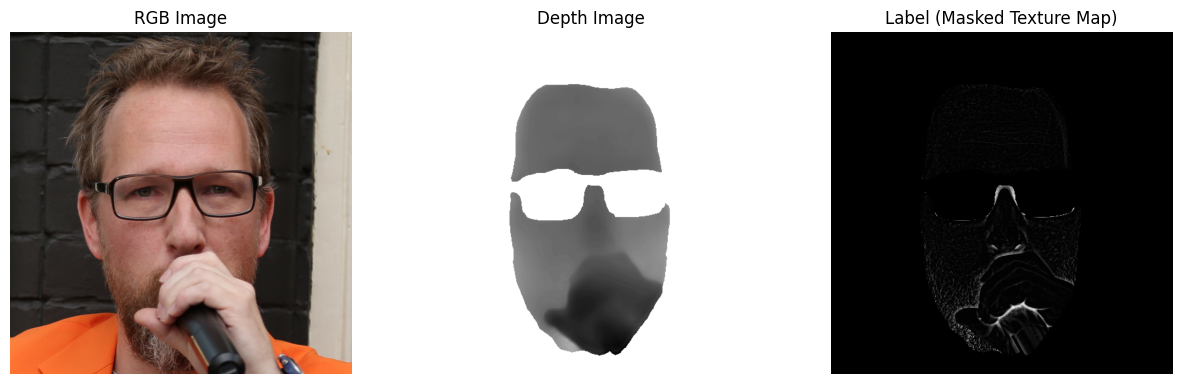

In [16]:
import matplotlib.pyplot as plt

# 샘플 이미지 시각화
def show_sample(idx):
    rgb_image = np.array(Image.open(rgb_paths[idx]).convert("RGB"))
    depth_image = np.array(Image.open(depth_paths[idx]).convert("L"))
    label_image = np.array(Image.open(label_paths[idx]).convert("L"))

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(rgb_image)
    axs[0].set_title('RGB Image')
    axs[0].axis('off')

    axs[1].imshow(depth_image, cmap='gray')
    axs[1].set_title('Depth Image')
    axs[1].axis('off')

    axs[2].imshow(label_image, cmap='gray')
    axs[2].set_title('Label (Masked Texture Map)')
    axs[2].axis('off')

    plt.show()

# 첫 번째 샘플 시각화
show_sample(4)


## Fine-tunning

In [ ]:
# Fine-tuning을 위한 UNet 모델 생성
unet_model = create_model(
    model_type="unet",
    in_channels=5,   # 입력 채널 수: RGB(3) + Depth(1) + Weak Texture Map(1)
    out_channels=2   # 출력 채널 수: Wrinkle(1) + Background(1)
).cuda()


In [ ]:
# Pretrained 모델 로드
checkpoint = torch.load('pretrained_unet.pth')
unet_model.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
class WrinkleDatasetFineTune(Dataset):
    def __init__(self, rgb_dir, depth_dir, weak_texture_dir, label_dir, file_names=None, transform=None):
        self.rgb_dir = rgb_dir
        self.depth_dir = depth_dir
        self.weak_texture_dir = weak_texture_dir
        self.label_dir = label_dir
        if file_names is None:
            self.file_names = sorted(os.listdir(rgb_dir))
        else:
            self.file_names = file_names
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]

        # RGB 이미지 로드
        rgb_image = np.array(Image.open(os.path.join(self.rgb_dir, file_name)).convert("RGB"))

        # Depth 이미지 로드
        depth_image = np.array(Image.open(os.path.join(self.depth_dir, file_name)).convert("L"))
        depth_image = np.expand_dims(depth_image, axis=-1)  # (H, W, 1)

        # Weak Texture Map 로드
        weak_texture = np.array(Image.open(os.path.join(self.weak_texture_dir, file_name)).convert("L"))
        weak_texture = np.expand_dims(weak_texture, axis=-1)  # (H, W, 1)

        # 5채널 입력 생성
        input_image = np.concatenate((rgb_image, depth_image, weak_texture), axis=-1)  # (H, W, 5)

        # Ground Truth 주름 마스크 로드
        label = np.array(Image.open(os.path.join(self.label_dir, file_name)).convert("L"))

        # Transform 적용
        if self.transform:
            augmented = self.transform(image=input_image, mask=label)
            input_image = augmented['image']
            label = augmented['mask']
        else:
            # ToTensor 변환
            input_image = ToTensorV2()(image=input_image)['image']
            label = ToTensorV2()(image=label)['image']

        return input_image, label


In [ ]:
def get_augmentations():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
        A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=0.2),
        A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.1), rotate=(-15, 15), shear=(-10, 10), p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406, 0.5, 0.5), std=(0.229, 0.224, 0.225, 0.25, 0.25)),  # 채널별로 설정
        ToTensorV2()
    ])


In [ ]:
# 데이터 경로 설정
rgb_dir = "../data/images1024x1024"
depth_dir = "../data/depth_masking"
weak_texture_dir = "../data/weak_wrinkle_masks"
label_dir = "../data/ground_truth_wrinkle_masks"

# 파일 이름 리스트 가져오기 (Pretraining과 동일하게)
# ...

# 변환 정의
train_transform = get_augmentations_finetune()
val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406, 0.5, 0.5), std=(0.229, 0.224, 0.225, 0.25, 0.25)),
    ToTensorV2()
])

# 데이터셋 생성
train_dataset = WrinkleDatasetFineTune(rgb_dir, depth_dir, weak_texture_dir, label_dir, file_names=train_file_names, transform=train_transform)
val_dataset = WrinkleDatasetFineTune(rgb_dir, depth_dir, weak_texture_dir, label_dir, file_names=val_file_names, transform=val_transform)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=14, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=14, shuffle=False, num_workers=4)


In [ ]:
# Soft Dice Loss 정의
class SoftDiceLoss(nn.Module):
    def forward(self, logits, targets):
        smooth = 1e-5

        # 로짓에 소프트맥스 적용
        logits = torch.softmax(logits, dim=1)
        # 타겟을 one-hot 인코딩
        targets = nn.functional.one_hot(targets.long(), num_classes=2).permute(0, 3, 1, 2).float()

        intersection = torch.sum(logits * targets)
        union = torch.sum(logits) + torch.sum(targets)

        dice_score = (2 * intersection + smooth) / (union + smooth)
        loss = 1 - dice_score

        return loss

criterion = SoftDiceLoss()


In [ ]:
optimizer = optim.AdamW(
    unet_model.parameters(),
    lr=0.0001,
    weight_decay=0.05,
    betas=(0.9, 0.999)
)

In [ ]:
# 학습 루프
epochs = 150  # 또는 300, 논문에 따라 설정
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    train_loss = train_epoch(train_loader, unet_model, criterion, optimizer)
    val_loss = validate_epoch(val_loader, unet_model, criterion)
    
    scheduler.step(epoch + 1)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [12]:
# 모델의 모든 레이어 이름과 크기 출력 (디버깅 용도)
for name, param in unet_model.named_parameters():
    print(f"{name}: {param.shape}")

model.0.conv.unit0.conv.weight: torch.Size([16, 4, 3, 3])
model.0.conv.unit0.conv.bias: torch.Size([16])
model.0.conv.unit0.adn.A.weight: torch.Size([1])
model.0.conv.unit1.conv.weight: torch.Size([16, 16, 3, 3])
model.0.conv.unit1.conv.bias: torch.Size([16])
model.0.conv.unit1.adn.A.weight: torch.Size([1])
model.0.residual.weight: torch.Size([16, 4, 3, 3])
model.0.residual.bias: torch.Size([16])
model.1.submodule.0.conv.unit0.conv.weight: torch.Size([32, 16, 3, 3])
model.1.submodule.0.conv.unit0.conv.bias: torch.Size([32])
model.1.submodule.0.conv.unit0.adn.A.weight: torch.Size([1])
model.1.submodule.0.conv.unit1.conv.weight: torch.Size([32, 32, 3, 3])
model.1.submodule.0.conv.unit1.conv.bias: torch.Size([32])
model.1.submodule.0.conv.unit1.adn.A.weight: torch.Size([1])
model.1.submodule.0.residual.weight: torch.Size([32, 16, 3, 3])
model.1.submodule.0.residual.bias: torch.Size([32])
model.1.submodule.1.submodule.0.conv.unit0.conv.weight: torch.Size([64, 32, 3, 3])
model.1.submodule.1